### Install Necessary Packages

Here is the baseline system, 

Output final ==> data, pre-processing, encoding, 

Scale down the audio so we can use less memory?

pre-trained model? 

Training and fine-tuning the model (training 3-4 times, average results and report results),

Output would be model 

print output and plot heatmaps in forward block (can we see more insights into how the model can capture genere?, Could be good to error analysis)

Wave2vec - base encoder, add FF elements and softmax and fine-tune

model.encoder.pre-trained 

start with audio for now

create three folders randomly (85/5/10) - read one directory, sort file names, take next 85%/5%/15% only take file name, go inside csv 

Huggingface wav2vec 2.0 source code -> models within models

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install transformers
%pip install torch
%pip install librosa
%pip install sklearn
%pip install pydub
%pip install soundfile

#ffmpeg is a dependency for pydub. Can install at the system level with:
# brew install ffmpeg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Load appropriate Libraries

In [2]:
import random
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Set Seed

In [3]:
def set_seed(seed_value=42):
    """Set seed for reproducibility for PyTorch and NumPy.

    Args:
        seed_value (int): The seed value to set for random number generators.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Additional steps for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)  # You can replace 42 with any other seed value of your choice

### Directory Management to work with Audio Data files

In [4]:
# # combine the zip files into single zip file
# %cat mp3.zip.* > single_mp3.zip

# # unzip the mp3 files
# %unzip mp3.zip

# #move all mp3 files into mp3 folder
# %find . -type f -name "*.wav" -exec mv {} ./mp3/ \;

# #remove all zip files
# %rm -r 0 1 2 3 4 5 6 7 8 9 a b c d e f

### Converting Audio in MP3 to WAV

In [5]:
# #Converting mp3 files to wav files. This takes ~75 minutes to run locally.

# import os
# from pydub import AudioSegment

# # Directory where mp3 files are stored
# mp3_dir = './mp3'

# #Directory where wav files will be saved
# wav_dir = './wav'

# #Checking to see if wav directory exists
# os.makedirs(wav_dir, exist_ok=True)

# #counter to keep track of audio files
# processed = 0

# #Loop through all mp3 files in mp3 directory
# for mp3 in os.listdir(mp3_dir):
#     if processed >= 26000:
#         break #stop processing files after the number above has been processed
    
#     if mp3.endswith('.mp3'):
#         mp3_path = os.path.join(mp3_dir, mp3)
#         try:
#             #Loading mp3 file
#             audio = AudioSegment.from_mp3(mp3_path)
            
#             #Create the output wav file path by changing the extension from mp3 to wav
#             wav_file = mp3.replace('.mp3', '.wav')
#             wav_path = os.path.join(wav_dir, wav_file)

#             #Export audio as wav file
#             audio.export(wav_path, format='wav')
#             print(f'Converted: {mp3} -> {wav_file}')
            
#             #Increment counter
#             processed += 1
#         except Exception as e:
#             print(f'Error converting: {mp3}: {str(e)}')

### Checking the distribution of the label data

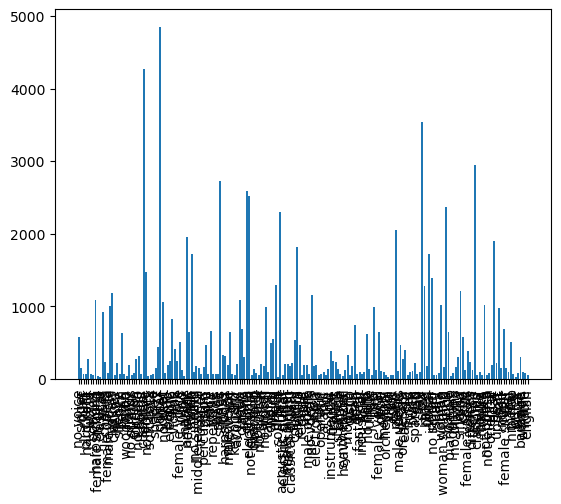

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

annotations = pd.read_csv('./annotations_final.csv', sep='\t')
# clip_data = pd.read_csv('./clip_info_final.csv', sep= '\t')

#Check shape of data

# !find ./wav/ -type f | wc -l 
#print(annotations.shape)
# print(clip_data.shape)

#for each column, count the number of 1s and store in a dictionary

annotations_dict = {}
for column in annotations.columns:
    annotations_dict[column] = annotations[column].sum()
    
#remove first and last column    
del annotations_dict['clip_id'], annotations_dict['mp3_path']

#visualize distribution of variables in annotations
plt.bar(annotations_dict.keys(), annotations_dict.values())

#make the plot bigger
plt.rcParams['figure.figsize'] = [50, 10]

#rotate x axis labels
plt.xticks(rotation=90)
#make font size bigger
plt.rcParams.update({'font.size': 21})
#change font 
plt.rcParams['font.family'] = 'sans-serif'
plt.show()


In [7]:
#print the average number of labels per clip

annotations_values = annotations_dict.values()
means = sum(annotations_values)/len(annotations_values)

above_average = []
above_1000 = []
above_2000 = []
above_3000 = []
above_4000 = []

for key, value in annotations_dict.items():
    if value > means:
        above_average.append(key)
    if value > 1000:
        above_1000.append(key)
    if value > 2000:
        above_2000.append(key)
    if value > 3000:
        above_3000.append(key)
    if value > 4000:
        above_4000.append(key)

print(f'Average number of labels per genre = {means.round()}')
print(f'We have {len(above_1000)} Genres with more than 1000 labels. They are: {above_1000}')
print(f'We have {len(above_2000)} Genres with more than 2000 labels. They are: {above_2000}')
print(f'We have {len(above_3000)} Genres with more than 3000 labels. They are: {above_3000}')
print(f'We have {len(above_4000)} Genres with more than 4000 labels. They are: {above_4000}')

Average number of labels per genre = 476.0
We have 28 Genres with more than 1000 labels. They are: ['harpsichord', 'male vocal', 'vocals', 'classical', 'female', 'guitar', 'quiet', 'ambient', 'synth', 'strings', 'loud', 'drums', 'electronic', 'opera', 'fast', 'violin', 'no vocals', 'piano', 'slow', 'male', 'vocal', 'indian', 'woman', 'rock', 'singing', 'techno', 'flute', 'beat']
We have 10 Genres with more than 2000 labels. They are: ['classical', 'guitar', 'strings', 'drums', 'electronic', 'fast', 'piano', 'slow', 'rock', 'techno']
We have 3 Genres with more than 3000 labels. They are: ['classical', 'guitar', 'slow']
We have 2 Genres with more than 4000 labels. They are: ['classical', 'guitar']


### Make sure paths for annotations and text metadata match with audio directory. Also that the file types are correct.

In [8]:
def clean_path(file):
    '''
    To clean the path of the file to merge the datasets
    '''
    file['mp3_path'] = file['mp3_path'] = file['mp3_path'].str.split('/').str[1] #replace the path with the correct path
    file['mp3_path'] = file['mp3_path'].str.replace('.mp3', '.wav') #change the file type to .wav

    #print the first few rows to check
    print(file['mp3_path'].head(3))
    
    return file

#clip_data_clean = clean_path(clip_data)
annotations_clean = clean_path(annotations)

#output the new clip_data_clean into csv to inspect

# clip_data_clean.to_csv('clip_data_clean.csv', index=False)
# annotations_clean.to_csv('annotations_clean.csv', index=False)

0    american_bach_soloists-j_s__bach_solo_cantatas...
1    american_bach_soloists-j_s__bach_solo_cantatas...
2    american_bach_soloists-j_s__bach_solo_cantatas...
Name: mp3_path, dtype: object


/var/folders/9m/nxnvhg5d02q780sbwrdh45140000gn/T/ipykernel_89463/4207391539.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  file['mp3_path'] = file['mp3_path'].str.replace('.mp3', '.wav') #change the file type to .wav


### Generate separate folders for test, train, validate 

In [9]:
# create three separate folders from the .wav files. One for train (85% of files), one for validation (5%) of files, and one for test (10%) of files.

# create a list of all the files in the wav directory
import os
import random
import shutil

#set the path to the wav files
wav_dir = './wav'

#set the path to the train, validation, and test folders
train_dir = './train'
valid_dir = './valid'
test_dir = './test'

#check if the folders exist, if not create them
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Get a sorted list of all the files in the wav directory
all_files = sorted(os.listdir(wav_dir))

#set the number of files to put into train folder
train_size = int(len(os.listdir(wav_dir)) * 0.85)

#set the number of files to put into valid folder
valid_size = int(len(os.listdir(wav_dir)) * 0.05)

#set the number of files to put into test folder
test_size = int(len(os.listdir(wav_dir)) * 0.1)

#Create list of first 85% of files to put into train folder
train_files = all_files[:train_size]

#Create list of the next 5% of files to put into valid folder
valid_files = all_files[train_size:train_size + valid_size]

#Create list of the next 10% of files to put into test folder
test_files = all_files[train_size + valid_size:]

#check the length of each list to make sure they add up to the total number of files
print(f'Total number of files: {len(all_files)}')
print(f'Number of files in train_list: {len(train_files)}')
print(f'Number of files in valid_list: {len(valid_files)}')
print(f'Number of files in test_list: {len(test_files)}')

#move the files into the correct folders

#move the train files
for file in train_files:
    shutil.move(os.path.join(wav_dir, file), train_dir)
    
#move the valid files
for file in valid_files:
    shutil.move(os.path.join(wav_dir, file), valid_dir)
    
#move the test files
for file in test_files:
    shutil.move(os.path.join(wav_dir, file), test_dir)
    
#check the number of files in each folder
train_files_in_folder = os.listdir(train_dir)
valid_files_in_folder = os.listdir(valid_dir)
test_files_in_folder = os.listdir(test_dir)
    
#check the number of files in each folder
print(f'Number of files in train_folder: {len(train_files_in_folder)}')
print(f'Number of files in valid_folder: {len(valid_files_in_folder)}')
print(f'Number of files in test_folder: {len(test_files_in_folder)}')


Total number of files: 0
Number of files in train_list: 0
Number of files in valid_list: 0
Number of files in test_list: 0
Number of files in train_folder: 21982
Number of files in valid_folder: 1294
Number of files in test_folder: 2587


In [10]:
#sort annotations file by mp3_path

annotations_clean = annotations_clean.sort_values(by=['mp3_path'])

#Function to use the files in each test, train, valid folder to split the annotations dataframe into three dataframes corresponding to each folder.

def test_train_valid (dir, annotations):
    x = ''
    if dir.startswith('train_dir'):
        x = 'train'
    elif dir.startswith('valid_dir'):
        x = 'valid'
    elif dir.startswith('test_dir'):
        x = 'test'
    
    file_list = os.listdir(dir)
    file_list = [file for file in file_list]
    
    #split the annotations dataframe based on the file names in the list
    subset_df = annotations[annotations['mp3_path'].isin(file_list)]
    
    return x, subset_df

# run the function on each folder
train_y, train_df = test_train_valid(train_dir, annotations_clean)
valid_y, valid_df= test_train_valid(valid_dir, annotations_clean)
test_y, test_df = test_train_valid(test_dir, annotations_clean)

#check the shape of each dataframe
print(f'Train shape: {train_df.shape}')
print (train_df['mp3_path'])
print(f'Valid shape: {valid_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (21981, 190)
504           aba_structure-epic-01-deep_step-117-146.wav
505           aba_structure-epic-01-deep_step-146-175.wav
506           aba_structure-epic-01-deep_step-175-204.wav
507           aba_structure-epic-01-deep_step-291-320.wav
508           aba_structure-epic-01-deep_step-320-349.wav
                              ...                        
4420    swar_prabhat-designer_bliss-02-saraswati_vanda...
4421    swar_prabhat-designer_bliss-02-saraswati_vanda...
4418    swar_prabhat-designer_bliss-02-saraswati_vanda...
4422    swar_prabhat-designer_bliss-02-saraswati_vanda...
4419    swar_prabhat-designer_bliss-02-saraswati_vanda...
Name: mp3_path, Length: 21981, dtype: object
Valid shape: (1293, 190)
Test shape: (2586, 190)


### Checking to see if all files in test, train, validate folders match those in the corresponding dataframes

In [11]:
if set(train_files_in_folder) == set(train_df['mp3_path']):
    print("The file names in the train folder match the file names in the train dataframe")
else:
    print("The file names in the train folder do not match the file names in the train dataframe")

if set(valid_files_in_folder) == set(valid_df['mp3_path']):
    print("The file names in the valid folder match the file names in the valid dataframe")
else:
    print("The file names in the valid folder do not match the file names in the valid dataframe")
    
if set(test_files_in_folder) == set(test_df['mp3_path']):
    print("The file names in the test folder match the file names in the test dataframe")
else:
    print("The file names in the test folder do not match the file names in the test dataframe")

The file names in the train folder do not match the file names in the train dataframe
The file names in the valid folder do not match the file names in the valid dataframe
The file names in the test folder do not match the file names in the test dataframe


### Additional Data Cleaning Steps to Get Data Ready for Training

In [12]:
#remove first two columns of train_df and valid_df
train_df = train_df.iloc[:, 1:]
valid_df = valid_df.iloc[:, 1:]
test_df = test_df.iloc[:, 1:]

#check the data type of columns in dataframe
print(train_df.dtypes)
print(valid_df.dtypes)
print(test_df.dtypes)

no voice      int64
singer        int64
duet          int64
plucking      int64
hard rock     int64
              ...  
baroque       int64
women         int64
fiddle        int64
english       int64
mp3_path     object
Length: 189, dtype: object
no voice      int64
singer        int64
duet          int64
plucking      int64
hard rock     int64
              ...  
baroque       int64
women         int64
fiddle        int64
english       int64
mp3_path     object
Length: 189, dtype: object
no voice      int64
singer        int64
duet          int64
plucking      int64
hard rock     int64
              ...  
baroque       int64
women         int64
fiddle        int64
english       int64
mp3_path     object
Length: 189, dtype: object


In [13]:
#export the dataframes to csv files
train_df.to_csv('train_df.csv', index=False)
valid_df.to_csv('valid_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

#move the csvs to correct folders
shutil.move('train_df.csv', train_dir)
shutil.move('valid_df.csv', valid_dir)
shutil.move('test_df.csv', test_dir)

Error: Destination path './train/train_df.csv' already exists

### Generate example train and validate datasets to test pre-processing and training code in Wav2Vec.ipynb

In [14]:
train_example = train_df[:50]
val_example = valid_df[:50]
test_example = test_df[:50]

# print(train_example['mp3_path'])

#change the data type of all columns to int except for the mp3_path column and the first two columns

# # # Select the columns you want to convert to integers (excluding 'mp3_path' and the first two columns)
# columns_to_convert = train_example.columns[:-1]

# # # Convert selected columns to integer
# train_example[columns_to_convert] = train_example[columns_to_convert].astype(float)
# val_example[columns_to_convert] = val_example[columns_to_convert].astype(float)

# Replace the path with the correct path
train_example.loc[:, 'mp3_path'] = 'train/' + train_example['mp3_path'].astype(str)
val_example.loc[:, 'mp3_path'] = 'valid/' + val_example['mp3_path'].astype(str)
test_example.loc[:, 'mp3_path'] = 'test/' + test_example['mp3_path'].astype(str)

print(train_example['mp3_path'])

# Save to CSV
train_example.to_csv('train_example.csv', index=False)

val_example.to_csv('valid_example.csv', index=False)
test_example.to_csv('test_example.csv', index=False)

504      train/aba_structure-epic-01-deep_step-117-146.wav
505      train/aba_structure-epic-01-deep_step-146-175.wav
506      train/aba_structure-epic-01-deep_step-175-204.wav
507      train/aba_structure-epic-01-deep_step-291-320.wav
508      train/aba_structure-epic-01-deep_step-320-349.wav
509      train/aba_structure-epic-01-deep_step-378-407.wav
510      train/aba_structure-epic-01-deep_step-436-465.wav
511      train/aba_structure-epic-01-deep_step-465-494.wav
512      train/aba_structure-epic-01-deep_step-494-523.wav
503        train/aba_structure-epic-01-deep_step-59-88.wav
3736      train/aba_structure-epic-02-luna_dub-204-233.wav
3737      train/aba_structure-epic-02-luna_dub-291-320.wav
3738      train/aba_structure-epic-02-luna_dub-349-378.wav
3734        train/aba_structure-epic-02-luna_dub-59-88.wav
3735       train/aba_structure-epic-02-luna_dub-88-117.wav
6062       train/aba_structure-epic-03-houseboats-0-29.wav
6066     train/aba_structure-epic-03-houseboats-117-146.

/var/folders/9m/nxnvhg5d02q780sbwrdh45140000gn/T/ipykernel_89463/259908339.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_example.loc[:, 'mp3_path'] = 'train/' + train_example['mp3_path'].astype(str)
/var/folders/9m/nxnvhg5d02q780sbwrdh45140000gn/T/ipykernel_89463/259908339.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_example.loc[:, 'mp3_path'] = 'valid/' + val_example['mp3_path'].astype(str)
/var/folders/9m/nxnvhg5d02q780sbwrdh45140000gn/T/ipykernel_89463/259908339.py:19: SettingWit

# MODEL ARCHITECTURE

In [ ]:
# from transformers import AutoProcessor, AutoModelForCTC
# from datasets import load_dataset
# import datasets
# import torch
# import torchaudio


# # load pretrained model and processor
# model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h")
# processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")

# def extract_audio_embeddings(audio_file_name):
#   audio_data, _= torchaudio.load(audio_file_name, sample_rate = 16000) #how many samples are processed per second.
#   input_tensors = processor(audio_data, return_tensors="pt", sampling_rate=16000).input_values #use processor to process audio file and return tensor of input values for model
#   with torch.no_grad():
#     embeddings = model(input_tensors).last_hidden_state.mean(dim=1) #take the mean of the last hidden state of the model to extract the embeddings
#   print (embeddings.shape)
#   return embeddings.flatten()

# e1 = extract_audio_embeddings("train/aba_structure-epic-01-deep_step-59-88.wav")

In [ ]:
# import torch
# import torchaudio
# from transformers import AutoModelForCTC, AutoProcessor

# # Load pretrained model and processor
# model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h")
# processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")

# def extract_audio_embeddings(audio_file_name):
#     try:
#         # Set the sampling rate
#         torchaudio.set_audio_backend("sox_io")
        
#         # Load audio data
#         audio_data, _ = torchaudio.load(audio_file_name, normalize=True)
        
#         # Process audio data
#         input_tensors = processor(audio_data[0].numpy(), return_tensors="pt", sampling_rate=16000).input_values
        
#         # Extract embeddings
#         with torch.no_grad():
#             embeddings = model(input_tensors).last_hidden_state.mean(dim=1)
        
#         print(f"Embeddings shape: {embeddings.shape}")
#         return embeddings.flatten()
#     except Exception as e:
#         print(f"Error processing audio file {audio_file_name}: {e}")
#         return None

# # Example usage
# e1 = extract_audio_embeddings("train/aba_structure-epic-01-deep_step-59-88.wav")


### Merge annotations and text metadata.

In [ ]:
# ### Merge the metadata and annotations file on mp3_path variable
# merge = pd.merge(clip_data_clean, annotations_clean, on='mp3_path', how='inner')

# # keep everything except: url, original_url, clip_id_y 
# merge.drop(['url', 'original_url', 'clip_id_y'], axis=1, inplace=True)

# #rename clip_id_x to clip_id
# merge.rename(columns={'clip_id_x' : 'clip_id'}, inplace=True)

# print(merge.shape)
# print(merge.head(5))
# #merge.to_csv('merge.csv', index=False)

### Create train, validate, test, split. (WIP)

In [ ]:

# #split train data into train and validation sets. Use stratified sampling to ensure equal class distribution in train and validation sets: https://www.geeksforgeeks.org/how-to-split-a-dataset-into-train-and-test-sets-using-python/

# #split merge into train, test and validate sets

# x_train, x_val, y_train, y_val = train_test_split(merge['text'], train['label'], test_size=0.05, random_state=42, stratify=train['label'])


# #check the shape of train and validation sets
# # print(f'----Shape_Check----')
# # print('\n')
# # print(f'The length of the original train and test set are: {len(train), len(test)}')
# # print(f'The length of text (x) for training and validation are: {x_train.shape, x_val.shape}.')
# # print(f'The length of labels (y) for training and validation are: {y_train.shape, y_val.shape}.')
# # print('\n')


### Extract Audio Features (WIP)

In [ ]:
# import librosa as lr
# import os

# #function to extract features from audio file

# audio_dir = './test'

# def extract_audio_features(audio_dir):
#     for filename in os.listdir(audio_dir):
#         if filename.endswith('.wav'):
#             audio_path = os.path.join(audio_dir, filename)
#             #load audio file
#             y, sr = lr.load(audio_path, sr = 22050) #y = audio signal over time, sr = sampling rate, or how manu audio samples are recorded per second. Default sampling rate of 22050 Hz.
#             #extract features
#             mfccs = lr.feature.mfcc(y=y, sr=sr) #mfcss = variable that stores the Mel-frequency cepstral coefficients (MFCCs) extracted from the audio. These capture the timbral/textural aspects of the audio signal (e.g. brightness, nasality, roughness, etc.). Default number of MFCCs to return is 20.
#             yield mfccs, mfccs #yield is a keyword that is used like return, except the function will return a generator. Generators are iterators, a kind of iterable you can only iterate over once. Generators do not store all the values in memory, they generate the values on the fly.

# #Process audio files using the generator
# for filename, mfccs in extract_audio_features(audio_dir):
#     print(f"Processed: {len(filename)}")

### Parallel Processing Approach to converting mp3 -> wav

In [ ]:
# import os
# from pydub import AudioSegment
# from concurrent.futures import ProcessPoolExecutor

# mp3_dir = './mp3'
# wav_dir = './wav'
# os.makedirs(wav_dir, exist_ok=True)

# def convert_mp3_to_wav(mp3):
#     try:
#         mp3_path = os.path.join(mp3_dir, mp3)
#         audio = AudioSegment.from_mp3(mp3_path)
#         wav_file = mp3.replace('.mp3', '.wav')
#         wav_path = os.path.join(wav_dir, wav_file)
#         audio.export(wav_path, format='wav')
#         print(f'Converted: {mp3} -> {wav_file}')
#     except Exception as e:
#         print(f'Error converting: {mp3}: {str(e)}')

# processed = 0
# max_files = 26000

# with ProcessPoolExecutor() as executor:
#     futures = {executor.submit(convert_mp3_to_wav, mp3): mp3 for mp3 in os.listdir(mp3_dir) if mp3.endswith('.mp3')}

#     for future in concurrent.futures.as_completed(futures):
#         mp3 = futures[future]
#         try:
#             future.result()
#             processed += 1
#         except Exception as e:
#             print(f'Error converting: {mp3}: {str(e)}')

#         if processed >= max_files:
#             break
